# Bayesian Neural Network for Landslide Susceptibility Mapping

This notebook implements a Bayesian Neural Network (BNN) to predict landslide susceptibility. It includes mathematical explanations of the variational inference process.

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns # Added for heatmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix # Added these imports
)

In [6]:
torch.manual_seed(42)

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
df = pd.read_csv('/content/EDA_data.csv')

In [9]:
df.head()

,Latitude,Longitude,Elevation,Slope,Aspect,Curvature,SPI,TWI,TRI,NDVI,LULC,Annual_Rainfall,Drainage_Density,Soil_Texture,Landslide
0,22.645184,92.197626,46,4.077521,310.236359,0.224299,-1.935804,-1.935804,1.987616,0.075623,7.0,57.196407,0.0,4.0,1
1,22.646482,92.197168,41,2.732584,127.874985,0.000000,-3.042220,-3.042220,1.286204,0.086853,7.0,57.211571,0.0,4.0,1
2,22.647297,92.195212,53,2.397054,90.000000,0.672897,-1.935804,-1.935804,1.490712,0.067504,7.0,57.211571,0.0,4.0,1
3,22.646742,92.193913,43,5.756790,265.236359,0.448598,-1.485546,-1.485546,2.748737,0.055501,7.0,57.227306,0.0,4.0,1
4,22.660147,92.155306,60,5.452793,254.744888,0.336448,-1.416456,-1.416456,4.876246,0.169679,7.0,57.192352,0.0,7.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latitude          498 non-null    float64
 1   Longitude         498 non-null    float64
 2   Elevation         498 non-null    int64  
 3   Slope             498 non-null    float64
 4   Aspect            498 non-null    float64
 5   Curvature         498 non-null    float64
 6   SPI               498 non-null    float64
 7   TWI               498 non-null    float64
 8   TRI               498 non-null    float64
 9   NDVI              498 non-null    float64
 10  LULC              498 non-null    float64
 11  Annual_Rainfall   498 non-null    float64
 12  Drainage_Density  498 non-null    float64
 13  Soil_Texture      498 non-null    float64
 14  Landslide         498 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 58.5 KB


In [10]:
feature_cols = [
    'Elevation', 'Slope', 'Aspect', 'Curvature',
    'SPI', 'TWI', 'TRI', 'NDVI', 'LULC',
    'Annual_Rainfall', 'Drainage_Density', 'Soil_Texture'
]

target_col = 'Landslide'

In [11]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[target_col]
)

In [12]:
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

StandardScaler()

In [13]:
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

X_train = scaler.transform(train_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_test  = test_df[target_col].values

In [14]:
# Dataset

class LandslideDataset(Dataset):
  def __init__(self,X,y,coords):
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
    self.coords=torch.tensor(coords,dtype=torch.float32)


  def __len__(self):
   return len(self.X)

  def __getitem__(self,idx):
   return self.X[idx], self.y[idx], self.coords[idx]

train_ds = LandslideDataset(X_train,y_train,train_df[['Latitude','Longitude']].values)
test_ds = LandslideDataset(X_test,y_test,test_df[['Latitude','Longitude']].values)

train_loader = DataLoader(train_ds,batch_size=64,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=64,shuffle=False)


## Bayesian Linear Layer

In a Bayesian Neural Network, weights and biases are modeled as probability distributions. We use a Gaussian distribution for the variational posterior:

$$q(w|\theta) \sim \mathcal{N}(\mu, \sigma^2)$$

### 1. Softplus Transformation
To ensure $\sigma > 0$:

$$\sigma = \log(1 + \exp(\rho))$$

### 2. Reparameterization Trick
To allow backpropagation:

$$w = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)$$

In [29]:
# Bayasina Neural Network

class BayesianLinear(nn.Module):
  def __init__(self,in_features,out_features, prior_sigma=1.0):
    super(). __init__()
    self.prior_sigma = prior_sigma

    # Mean parameters for weight distribution (initialized to zeros)
    self.weight_mu = nn.Parameter(torch.zeros(out_features,in_features))
    # Rho parameter for weight distribution (transformed to sigma via softplus)
    # Initialized to -5 to make initial sigma small (~0.0067)
    self.weight_rho = nn.Parameter(torch.ones(out_features,in_features)*-5)

    # Mean parameters for bias distribution (initialized to zeros)
    self.bias_mu = nn.Parameter(torch.zeros(out_features))
    # Rho parameter for bias distribution (transformed to sigma via softplus)
    # Initialized to -5 to make initial sigma small (~0.0067)
    self.bias_rho = nn.Parameter(torch.ones(out_features)*-5)

  def forward(self,x):
    # Transform rho to sigma using softplus: σ = log(1 + exp(ρ))
    # This ensures sigma is always positive
    weight_sigma = torch.log1p(torch.exp(self.weight_rho))
    bias_sigma = torch.log1p(torch.exp(self.bias_rho))

    # Reparameterization trick: sample from N(μ, σ²) as μ + σ·ε where ε ~ N(0, 1)
    # This allows backpropagation through random sampling
    weight = self.weight_mu + weight_sigma*torch.randn_like(self.weight_mu)
    bias = self.bias_mu + bias_sigma*torch.randn_like(self.bias_mu)

    # Standard linear transformation: y = xWᵀ + b
    return nn.functional.linear(x,weight,bias)

## KL Divergence

The KL divergence between the learned posterior and the prior:

$$\text{KL}[q(w|\theta) || p(w)] = \log \frac{\sigma_{prior}}{\sigma_q} + \frac{\sigma_q^2 + (\mu_q - \mu_{prior})^2}{2\sigma_{prior}^2} - \frac{1}{2}$$

In [30]:
# KL Divergence - Measures difference between learned distribution and prior distribution

def kl_divergence(layer):
  # Transform rho parameters to sigma (standard deviation) using softplus
  weight_sigma = torch.log1p(torch.exp(layer.weight_rho))  # σ_w = softplus(ρ_w)
  bias_sigma = torch.log1p(torch.exp(layer.bias_rho))      # σ_b = softplus(ρ_b)

  # KL divergence for weights: KL[q(w) || p(w)] where:
  # q(w) ~ N(μ_w, σ_w²) is the learned posterior distribution
  # p(w) ~ N(0, prior_sigma²) is the prior distribution (assumed zero-mean Gaussian)
  kl_w = torch.sum(
      # Term 1: log(σ_prior / σ_w) = log(σ_prior) - log(σ_w)
      torch.log(layer.prior_sigma / weight_sigma) +
      # Term 2: (σ_w² + μ_w²) / (2·σ_prior²)
      (weight_sigma**2 + layer.weight_mu**2) /
      (2 * layer.prior_sigma**2) - 0.5  # Term 3: -1/2
  )
  # Complete formula: KL = log(σ_prior/σ_q) + (σ_q² + μ_q²)/(2σ_prior²) - 1/2

  # KL divergence for biases (same formula as for weights)
  kl_b = torch.sum(
      # Term 1: log(σ_prior / σ_b)
      torch.log(layer.prior_sigma / bias_sigma) +
      # Term 2: (σ_b² + μ_b²) / (2·σ_prior²)
      (bias_sigma**2 + layer.bias_mu**2) /
      (2 * layer.prior_sigma**2) - 0.5  # Term 3: -1/2
  )

  # Total KL divergence is sum of weight and bias divergences
  return kl_w + kl_b


## Bayesian Neural Network Model

Stacking `BayesianLinear` layers to form the network.

In [31]:
# Bayesian Neural Network

class BayesianNN(nn.Module):
  def __init__(self, input_dim):
    super(). __init__()

    self.fc1 = BayesianLinear(input_dim, 64)
    self.fc2 = BayesianLinear(64, 32)
    self.fc3 = BayesianLinear(32, 1)

  def forward (self, x):
    x = torch.relu((self.fc1(x)))
    x = torch.relu((self.fc2(x)))
    return self.fc3(x)


  def Kl_loss(self):
    return(
        kl_divergence(self.fc1) +
        kl_divergence(self.fc2) +
        kl_divergence(self.fc3)
    )


model = BayesianNN(len(feature_cols)).to(device)

## Evidence Lower Bound (ELBO) Loss

$$\text{Loss} = \text{KL}[q(w|\theta) || p(w)] - \mathbb{E}_{q(w|\theta)}[\log p(y|x, w)]$$

In [32]:
# Training ELBO (Evidence Lower Bound)
# ELBO = Expected Log Likelihood - KL Divergence
# We maximize ELBO (or minimize negative ELBO) for Bayesian inference

# Adam optimizer for gradient-based optimization of variational parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Binary Cross Entropy with Logits Loss for binary classification
# Combines sigmoid activation and BCE loss for numerical stability
criterion = nn.BCEWithLogitsLoss()

# Number of training iterations over the entire dataset
epochs = 50

for epoch in range(epochs):
  # Set model to training mode (important for dropout, batch norm, and sampling)
  model.train()
  epoch_loss = 0.0  # Track cumulative loss for this epoch

  # Iterate through training data in batches
  for X, y, coords in train_loader: # Unpack all three values
    # Move data to appropriate device (CPU/GPU)
    X = X.to(device)
    y = y.to(device)
    # coords = coords.to(device) # If coords are needed on device, uncomment this line

    # Reset gradients from previous iteration
    optimizer.zero_grad()

    # Forward pass: sample weights from posterior and compute predictions
    # This uses the reparameterization trick for differentiable sampling
    logits = model(X)  # Unnormalized log-probabilities (before sigmoid)

    # Compute negative log-likelihood (data fit term)
    # Measures how well predictions match ground truth labels
    likelihood = criterion(logits, y.unsqueeze(1))  # Shape: (batch_size, 1)

    # Compute KL divergence (complexity penalty/regularization term)
    # Measures divergence from prior to learned posterior distribution
    # Normalized by dataset size for proper scaling in variational inference
    kl = model.Kl_loss() / len(train_ds)  # Average over entire dataset

    # ELBO loss: Negative ELBO = NLL + KL (we minimize this)
    # Equivalent to: loss = -ELBO = -(E[log p(y|x,w)] - KL[q(w)||p(w)])
    loss = likelihood + kl

    # Backpropagation: compute gradients through computational graph
    loss.backward()

    # Update variational parameters (μ and ρ) using gradients
    optimizer.step()

    # Accumulate loss for monitoring
    epoch_loss += loss.item()

  # Print epoch statistics (average loss per batch)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

Epoch 1/50, Loss: 33.993675231933594
Epoch 2/50, Loss: 33.941206795828684
Epoch 3/50, Loss: 33.88858250209263
Epoch 4/50, Loss: 33.836055755615234
Epoch 5/50, Loss: 33.77899387904576
Epoch 6/50, Loss: 33.71422576904297
Epoch 7/50, Loss: 33.63955307006836
Epoch 8/50, Loss: 33.542297908238005
Epoch 9/50, Loss: 33.460615975516184
Epoch 10/50, Loss: 33.37921360560826
Epoch 11/50, Loss: 33.31274141584124
Epoch 12/50, Loss: 33.247044699532644
Epoch 13/50, Loss: 33.170130593436106
Epoch 14/50, Loss: 33.131697518484934
Epoch 15/50, Loss: 33.06505530221121
Epoch 16/50, Loss: 33.01078741891043
Epoch 17/50, Loss: 32.97554506574358
Epoch 18/50, Loss: 32.88741520472935
Epoch 19/50, Loss: 32.83958925519671
Epoch 20/50, Loss: 32.78243201119559
Epoch 21/50, Loss: 32.72615759713309
Epoch 22/50, Loss: 32.65854481288365
Epoch 23/50, Loss: 32.60303769792829
Epoch 24/50, Loss: 32.55859592982701
Epoch 25/50, Loss: 32.50417273385184
Epoch 26/50, Loss: 32.43243735177176
Epoch 27/50, Loss: 32.400887625558035
E

## Monte Carlo Prediction

Predictive mean:
$$\bar{p} = \frac{1}{S} \sum_{s=1}^S p(y|x, w_s)$$

Predictive uncertainty:
$$\sigma_p = \sqrt{\frac{1}{S} \sum_{s=1}^S (p(y|x, w_s) - \bar{p})^2}$$

In [35]:
# Monte Carlo Prediction
# Uses multiple forward passes with different weight samples to estimate
# predictive uncertainty in Bayesian neural networks

def mc_predict(model, X, mc_samples=50):
    # Set model to evaluation mode
    # This is important for layers like dropout and batch norm that behave differently during eval
    # In Bayesian neural networks, eval mode still samples weights (unlike deterministic networks)
    model.eval()
    preds = []  # Store predictions from each Monte Carlo sample

    # Move input data to the same device as the model (CPU/GPU)
    X = X.to(device)

    # Disable gradient computation for efficiency and to prevent backprop during inference
    with torch.no_grad():
        # Perform multiple forward passes with different weight samples
        for _ in range(mc_samples):
            # Forward pass with random weight sampling from posterior
            # Each iteration samples a new set of weights from q(w|θ)
            logits = model(X)  # Get unnormalized log-probabilities

            # Apply sigmoid to convert logits to probabilities [0, 1]
            # σ(x) = 1 / (1 + exp(-x))
            probs = torch.sigmoid(logits)

            # Store probabilities for this Monte Carlo sample
            # Move to CPU and convert to numpy for aggregation
            preds.append(probs.cpu().numpy())

    # Stack all predictions into a 3D array: (mc_samples, batch_size, 1)
    preds = np.stack(preds)

    # Compute statistics across Monte Carlo samples:
    # mean = 𝔼_q(w)[p(y=1|x,w)] ≈ (1/S) Σ_s p(y=1|x,w_s)
    # std = √Var[p(y=1|x,w)] - measures uncertainty in predictions
    return preds.mean(axis=0).ravel(), preds.std(axis=0).ravel()

# Prepare test data for prediction
# Convert numpy array to PyTorch tensor with appropriate data type
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Perform Monte Carlo prediction
# Returns:
# - mean_prob: average predicted probability across samples
# - std_prob: standard deviation of predicted probabilities (uncertainty measure)
mean_prob, std_prob = mc_predict(model, X_test_tensor, mc_samples=50)

Epoch 1/50, Loss: 28.4745
Epoch 2/50, Loss: 28.4353
Epoch 3/50, Loss: 28.3914
Epoch 4/50, Loss: 28.3169
Epoch 5/50, Loss: 28.2918
Epoch 6/50, Loss: 28.2261
Epoch 7/50, Loss: 28.1650
Epoch 8/50, Loss: 28.1162
Epoch 9/50, Loss: 28.0467
Epoch 10/50, Loss: 28.0172
Epoch 11/50, Loss: 27.9715
Epoch 12/50, Loss: 27.9067
Epoch 13/50, Loss: 27.8531
Epoch 14/50, Loss: 27.8040
Epoch 15/50, Loss: 27.7607
Epoch 16/50, Loss: 27.6987
Epoch 17/50, Loss: 27.6458
Epoch 18/50, Loss: 27.6007
Epoch 19/50, Loss: 27.5529
Epoch 20/50, Loss: 27.4997
Epoch 21/50, Loss: 27.4507
Epoch 22/50, Loss: 27.3850
Epoch 23/50, Loss: 27.3422
Epoch 24/50, Loss: 27.2862
Epoch 25/50, Loss: 27.2500
Epoch 26/50, Loss: 27.1928
Epoch 27/50, Loss: 27.1358
Epoch 28/50, Loss: 27.0810
Epoch 29/50, Loss: 27.0305
Epoch 30/50, Loss: 26.9786
Epoch 31/50, Loss: 26.9341
Epoch 32/50, Loss: 26.8767
Epoch 33/50, Loss: 26.8394
Epoch 34/50, Loss: 26.7624
Epoch 35/50, Loss: 26.7162
Epoch 36/50, Loss: 26.6809
Epoch 37/50, Loss: 26.6089
Epoch 38/5

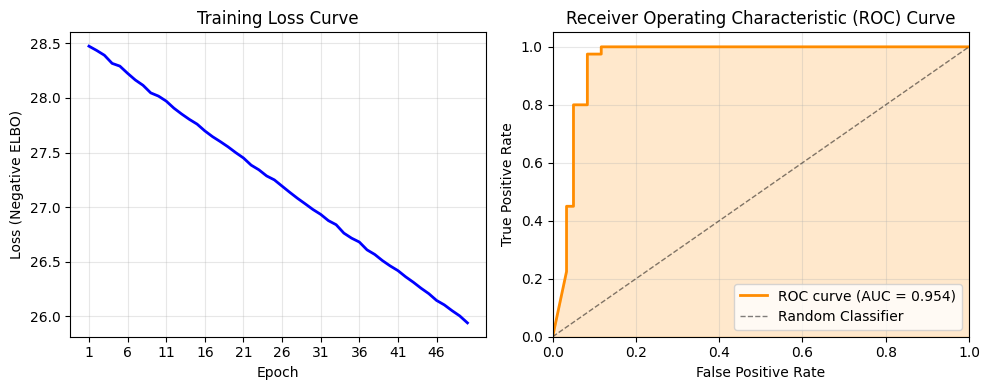

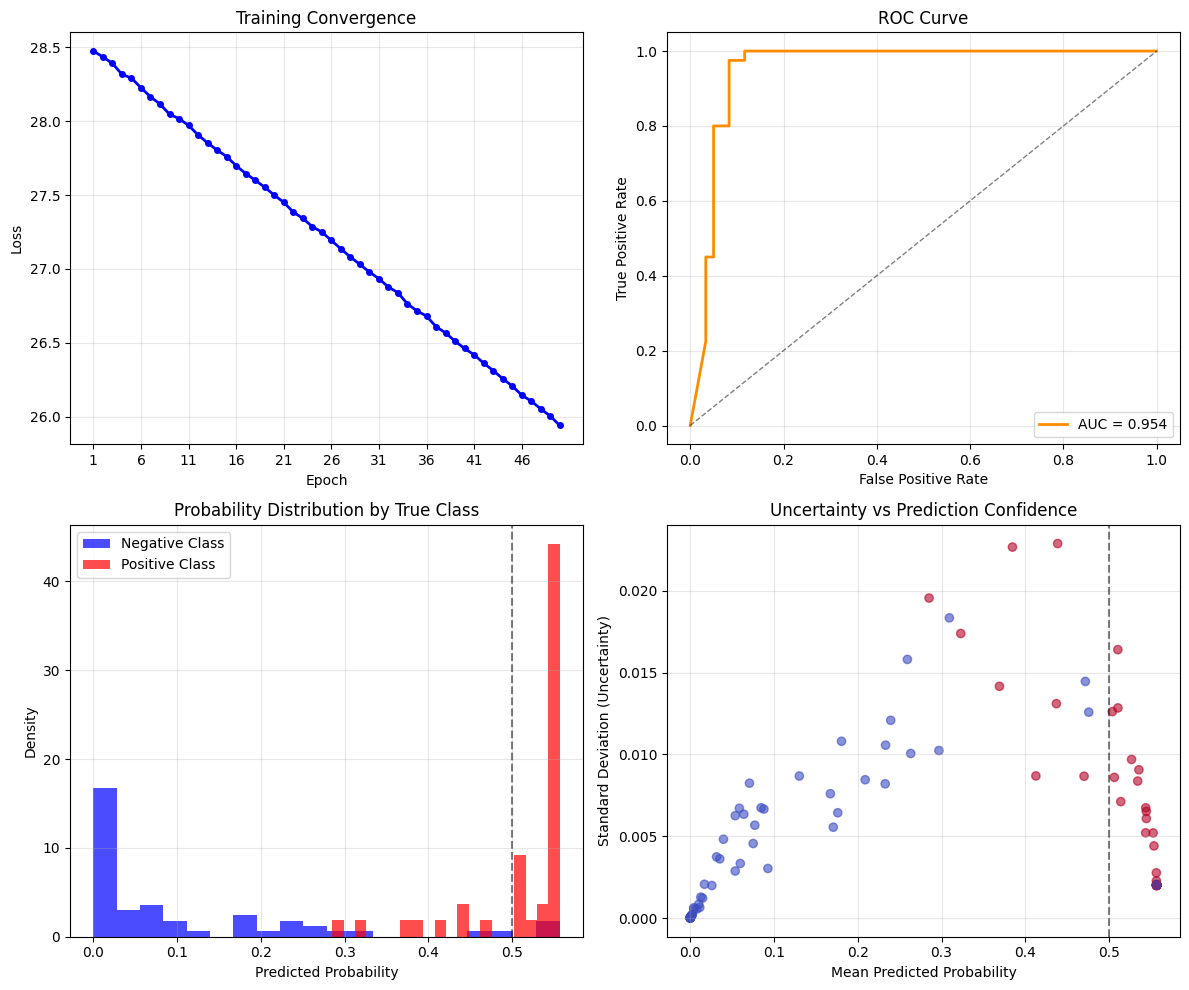


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       0.88      0.95      0.91        60
     Class 1       0.91      0.80      0.85        40

    accuracy                           0.89       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



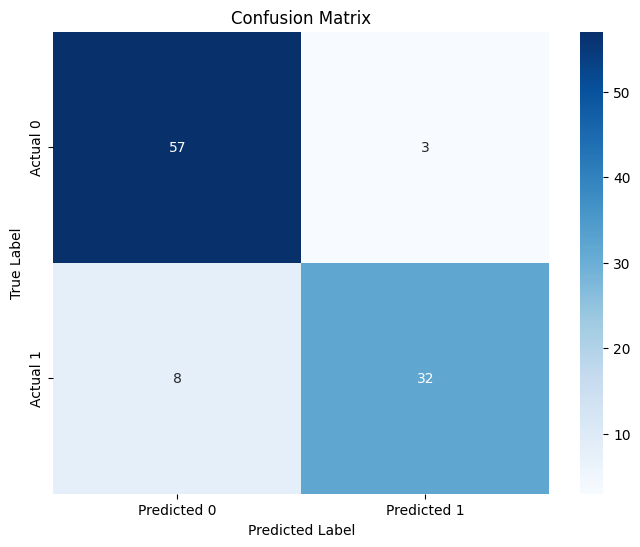

In [40]:
# ============================================================
# 11. Training Metrics (Epoch vs Loss Curve)
# ============================================================

# Store training losses for visualization
train_losses = []

# Training loop (modified to store losses)
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X, y, coords in train_loader: # Unpack all three values
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        logits = model(X)
        likelihood = criterion(logits, y.unsqueeze(1))
        kl = model.Kl_loss() / len(train_ds)
        loss = likelihood + kl

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)  # Store for plotting

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

# Plot Epoch vs Loss curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative ELBO)')
plt.title('Training Loss Curve')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, epochs + 1, max(1, epochs//10)))

# ============================================================
# 12. Classification Metrics
# ============================================================

# Convert mean probabilities to class predictions (threshold = 0.5)
y_pred = (mean_prob >= 0.5).astype(int)

print("\n" + "="*50)
print("CLASSIFICATION PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, mean_prob):.4f}")

# ============================================================
# 13. ROC Curve
# ============================================================

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mean_prob)
roc_auc = roc_auc_score(y_test, mean_prob)

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 14. Additional Visualizations
# ============================================================

# Create a 2x2 grid for comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Training Loss Curve
axes[0, 0].plot(range(1, epochs + 1), train_losses, 'b-o', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Convergence')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, epochs + 1, max(1, epochs//10)))

# Plot 2: ROC Curve
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'AUC = {roc_auc:.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Probability Distribution by True Class
axes[1, 0].hist(mean_prob[y_test == 0], bins=20, alpha=0.7,
                color='blue', label='Negative Class', density=True)
axes[1, 0].hist(mean_prob[y_test == 1], bins=20, alpha=0.7,
                color='red', label='Positive Class', density=True)
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Probability Distribution by True Class')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Uncertainty vs Prediction
axes[1, 1].scatter(mean_prob, std_prob, alpha=0.6, c=y_test, cmap='coolwarm')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Mean Predicted Probability')
axes[1, 1].set_ylabel('Standard Deviation (Uncertainty)')
axes[1, 1].set_title('Uncertainty vs Prediction Confidence')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 15. Detailed Classification Report
# ============================================================

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()